In [41]:
%matplotlib notebook

# 1. Generating orientations

### A regular grid from a spherical mesh
The output is euler angles of orientations, with the first euler angle constrained to 0

In [359]:
from diffsims.generators.rotation_list_generators import get_beam_directions_grid

grid = get_beam_directions_grid("cubic",1, mesh="spherified_cube_corner")

/Users/nielscautaerts/Documents/PythonProjects/FORKS/diffsims/diffsims/generators/sphere_mesh_generators.py:481: RuntimeWarning: invalid value encountered in true_divide
  phi2 = sign * np.nan_to_num(np.arccos(x_comp / norm_proj))


In [360]:
grid.shape

(1596, 3)

### A random grid
We sample the sphere after https://mathworld.wolfram.com/SpherePointPicking.html. We then map the beam directions to the fundamental zone of the cube, all directions contained in the solid angle spanned by 001-101-111. Again here the first euler angle will be constrained

In [361]:
import numpy as np
from diffsims.generators.sphere_mesh_generators import beam_directions_grid_to_euler

In [362]:
# random sampling in the fundamental cube zone
def _get_random_orientations_fundamental_cube(number):
    """after https://mathworld.wolfram.com/SpherePointPicking.html"""
    xyz = np.random.normal(size=(number, 3))
    xyz = np.abs(xyz.T/np.linalg.norm(xyz, axis=1)).T
    xyz = np.sort(xyz, axis=1)
    xyz[:, [0, 1]] = xyz[:, [1, 0]] 
    return beam_directions_grid_to_euler(xyz)
    

In [363]:
random_grid = _get_random_orientations_fundamental_cube(grid.shape[0])

### Verifying the grids
We map the grid onto the stereographic projection

In [364]:
from orix.quaternion.rotation import Rotation
from orix.vector.vector3d import Vector3d
rotations_regular =  Rotation.from_euler(np.deg2rad(grid))
rotations_random =  Rotation.from_euler(np.deg2rad(random_grid))
rot_reg_test = rotations_regular*Vector3d.zvector()
rot_rand_test = rotations_random*Vector3d.zvector()

In [365]:
import matplotlib.pyplot as plt

In [366]:
from orix.plot.stereo_plot import StereoPlot

<IPython.core.display.Javascript object>


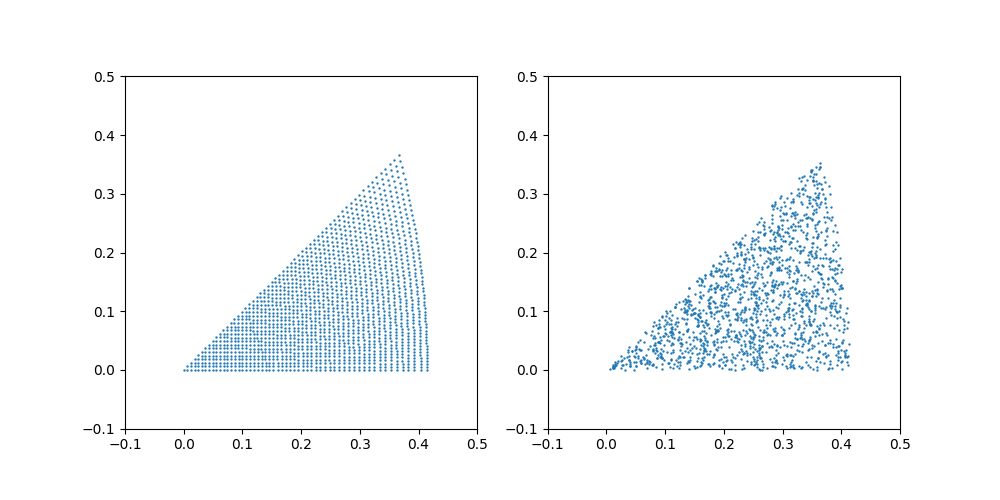

(-0.1, 0.5)

In [367]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), subplot_kw={"projection": "stereographic"})
ax1, ax2 = ax.ravel()
ax1.scatter(rot_reg_test, s = 0.5)
ax2.scatter(rot_rand_test, s = 0.5)
ax1.set_xlim(-0.1, 0.5)
ax1.set_ylim(-0.1, 0.5)
ax2.set_xlim(-0.1, 0.5)
ax2.set_ylim(-0.1, 0.5)

### Releasing the constraint on the third angle
All the orientations inside this triangle will be unique for the cubic crystal system with no overlap. We can now freely choose the third euler angle on a uniform distribution to get access to all possible unique orientations of the cube. Only exactly in the coorners will there be additional symmetry: at the 001 corner 4 times rotational symmetry, at the 101 corner 2 times, at the 111 corner 3 times.

In [368]:
random_grid[:, 0] = np.random.uniform(0, 360, size=random_grid.shape[0])
random_grid.shape

(1596, 3)

# 2. Generating a diffraction pattern simulation
* Loading a structure
* Set up the simulation
* Generate library

In [369]:
from diffsims.libraries.structure_library import StructureLibrary
from diffsims.generators.diffraction_generator import DiffractionGenerator
from diffsims.generators.library_generator import DiffractionLibraryGenerator

In [370]:
import diffpy
structure_aus = diffpy.structure.loadStructure("Data/austeniteLP.cif")

In [371]:
# diffraction generator controls how the patterns will be simulated
diff_gen = DiffractionGenerator(accelerating_voltage=200, shape_factor_model="lorentzian")

Extract relevant information from the image

In [372]:
import hyperspy.api as hs
from tqdm import tqdm

In [373]:
experimental_data = hs.load("data/subset_data.hspy")

In [374]:
experimental_data.axes_manager

<Axes manager, axes: (2, 2|256, 256)>
            Name |   size |  index |  offset |   scale |  units 
================ | ====== | ====== | ======= | ======= | ====== 
               x |      2 |      0 |   2e+02 |       2 |     nm 
               y |      2 |      0 |   2e+02 |       2 |     nm 
---------------- | ------ | ------ | ------- | ------- | ------ 
              kx |    256 |        |    -1.6 |   0.013 | $A^{-1}$ 
              ky |    256 |        |    -1.6 |   0.013 | $A^{-1}$

### Manual loop

In [375]:
# experimental values necessary to scale the simulations
half_width_image = experimental_data.axes_manager["kx"].size//2
diffraction_scale = experimental_data.axes_manager["kx"].scale
reciprocal_radius = np.sqrt(2)*half_width_image*diffraction_scale

simulations = []
for orientation in tqdm(grid):
    simulation = diff_gen.calculate_ed_data(
        structure_aus,
        reciprocal_radius,
        orientation,
        with_direct_beam=False,
        max_excitation_error=0.6e-1,
    )
    simulation.calibration = diffraction_scale
    simulations.append(simulation)

100%|██████████| 1596/1596 [00:20<00:00, 77.42it/s]


### The "recommended" way to generate the simulations is with Generating with the librarygenerator

In [ ]:
# list of phase names, list of structures, list of orientation grids to simulate
library_aus = StructureLibrary(["steel"], [structure_aus], [grid])
lib_gen = DiffractionLibraryGenerator(diff_gen)
diff_lib = lib_gen.get_diffraction_library(library_aus,
                                           calibration=diffraction_calibration,
                                           reciprocal_radius=reciprocal_radius,
                                           half_shape=(half_width_image, half_width_image),
                                           with_direct_beam=False)

### Plotting the results

In [376]:
test_simulation = simulations[0] #0 corresponds to 001 diffraction pattern

<IPython.core.display.Javascript object>


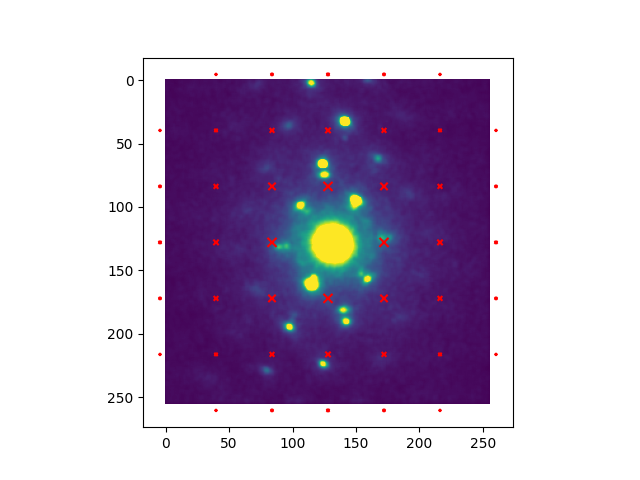

In [377]:
fig, ax = plt.subplots()
ax.imshow(experimental_data.inav[0,0], vmax=1000)

coords = test_simulation.calibrated_coordinates
coords[:, 0] += half_width_image
coords[:, 1] += half_width_image

ax.scatter(coords[:,0], coords[:,1], s = np.sqrt(test_simulation.intensities), color="red", marker="x")

# 3. Matching in-plane orientation

In [378]:
from skimage.transform import warp_polar

In [379]:
image = experimental_data.inav[0,0].data

In [380]:
center_coordinates = np.where(image == image.max())
polar_image = warp_polar(image, center=center_coordinates)
polar_image.shape

(360, 182)

<IPython.core.display.Javascript object>


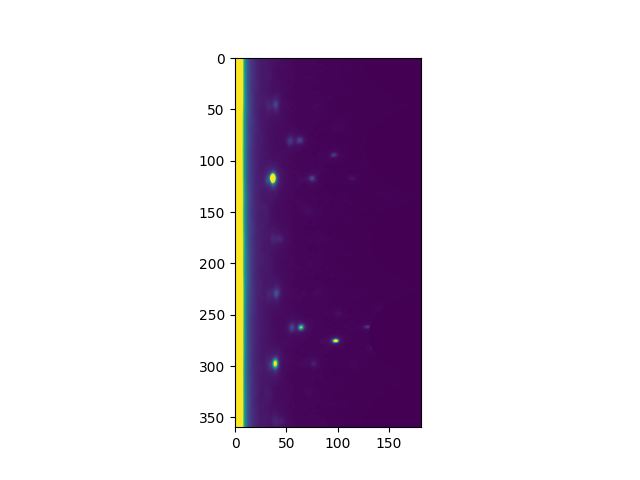

In [381]:
fig, ax = plt.subplots()
ax.imshow(polar_image, vmax=0.1)

# To work with numba more easily, convert list to array

In [382]:
num_spots = [i.intensities.shape[0] for i in simulations]
max_spots = max(num_spots)
positions = np.zeros((max_spots, 2, len(simulations)))
intensities = np.zeros((max_spots, len(simulations)))
for i, j in enumerate(simulations):
    x = j.calibrated_coordinates[:,0]
    y = j.calibrated_coordinates[:,1]
    intensity = j.intensities/np.linalg.norm(j.intensities)
    positions[:x.shape[0],0,i]=x
    positions[:y.shape[0],1,i]=y
    intensities[:intensity.shape[0], i]=intensity

In [383]:
print(intensities.shape)
print(positions.shape)

(66, 1596)
(66, 2, 1596)


### Helper functions for transformations

In [384]:
from numba import jit, njit, vectorize, guvectorize, prange

In [385]:
@njit
def _cartesian_to_polar(pixel_coords):
    polar_coords = np.zeros_like(pixel_coords)
    imag = (pixel_coords[:,0])+1j*(pixel_coords[:,1])
    polar_coords[:, 0] = np.abs(imag)
    polar_coords[:, 1] = np.angle(imag)/np.pi/2*360
    polar_coords[:, 1] = np.mod(polar_coords[:, 1], 360)
    return polar_coords

In [386]:
%%time
polar_test = _cartesian_to_polar(test_simulation.calibrated_coordinates)

CPU times: user 500 ms, sys: 11 ms, total: 511 ms
Wall time: 529 ms


In [387]:
# shift the points in polar coordinates manually
# it is assumed intensity vectors are already normalized!
@njit
def match_polar_to_template(polar_image, xy_coordinates, intensity, d_r):
    d_theta = 360/polar_image.shape[0]
    polar_coords = _cartesian_to_polar(xy_coordinates)
    r_template = np.rint(polar_coords[:, 0]/d_r)
    theta_template = np.rint(polar_coords[:, 1]/d_theta)
    condition = r_template < polar_image.shape[1]
    r_template = r_template[condition].astype(np.uint16)
    theta_template = theta_template[condition]
    intensity = intensity[condition]
    correlation = np.zeros(polar_image.shape[0])
    for i in prange(polar_image.shape[0]):
        theta_compare = np.mod(theta_template + i, polar_image.shape[0]).astype(np.uint16)
        image_intensities = np.zeros_like(theta_compare, dtype=np.float64)
        for j in range(theta_compare.shape[0]):
            yy = theta_compare[j]
            xx = r_template[j]
            image_intensities[j] = polar_image[yy, xx]
        correlation[i] = np.sum(image_intensities * intensity)
    return correlation
    
@njit(parallel=True)
def match_library_to_polar(polar_image, coordinates, intensities, d_r):
    correlations = np.zeros(intensities.shape[1])
    angles = np.zeros(intensities.shape[1])
    correlations_180 = np.zeros(intensities.shape[1])
    d_theta = 360/polar_image.shape[0]
    half_index = polar_image.shape[0]//2
    for i in prange(intensities.shape[1]):
        intensity = intensities[:, i]
        xy = coordinates[:, :, i]
        match = match_polar_to_template(polar_image, xy, intensity, d_r)
        half_match = match[:half_index]
        max_index = np.where(half_match == np.max(half_match))[0][0]
        correlations[i] = half_match[max_index]
        angles[i] = max_index*d_theta
        correlations_180[i] = match[max_index + half_index]
    return angles, correlations, correlations_180


In [389]:
%%time
cor = match_polar_to_template(polar_image, test_simulation.calibrated_coordinates, test_simulation.intensities, 1)

CPU times: user 651 µs, sys: 14 µs, total: 665 µs
Wall time: 661 µs


<IPython.core.display.Javascript object>


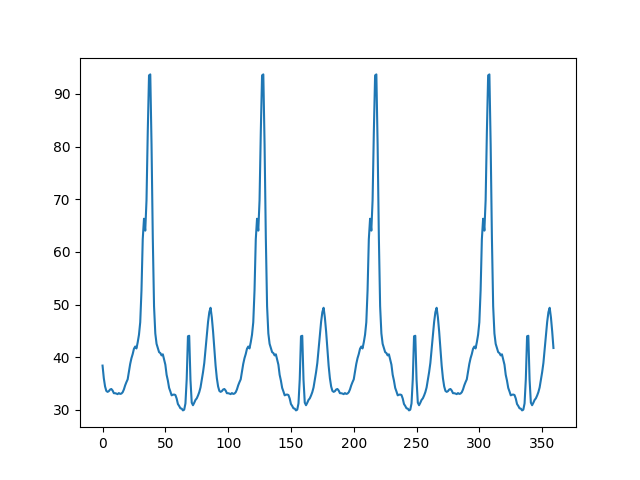

In [390]:
fig, ax = plt.subplots()
ax.plot(np.arange(cor.shape[0]), cor)

In [392]:
%%time
angles, correlations, correlations_180 = match_library_to_polar(polar_image, positions, intensities, 1)

CPU times: user 1.6 s, sys: 11.4 ms, total: 1.61 s
Wall time: 502 ms


### Verification of the result via plot

In [393]:
# make an interpolation
from orix.projections.stereographic_projection import StereographicProjection
from scipy.interpolate import griddata
xy = StereographicProjection.project(rot_reg_test)
z = correlations
xi = np.linspace(-0.1, 0.5, 1000)
yi = np.linspace(-0.1, 0.5, 1000)
Xi, Yi = np.meshgrid(xi, yi)
zi = griddata(xy, z, (Xi, Yi), method='cubic')

<IPython.core.display.Javascript object>


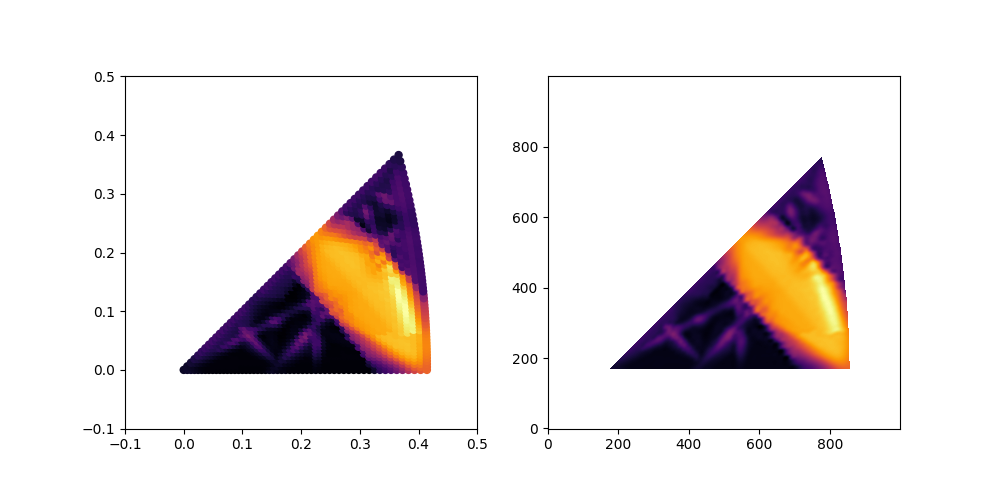

(-0.1, 0.5)

In [394]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), subplot_kw={"projection": "stereographic"})
ax1, ax2 = ax.ravel()
ax1.scatter(rot_reg_test, s = 25, c = correlations, cmap="inferno")
ax2.imshow(zi, cmap="inferno")
ax2.invert_yaxis()
ax1.set_xlim(-0.1, 0.5)
ax1.set_ylim(-0.1, 0.5)

In [395]:
# Wrap the above stuff a bit more in pythonic way

In [ ]:
def match_orientations(image, template_coordinates, template_intensities,
                       angular_increment=1, radial_increment=1):
    r_max = int(np.ceil(np.sqrt(np.sum(np.square(np.array(image.shape)/2)))))
    output_shape = (int(np.rint(360/angular_increment)), int(np.rint(r_max/radial_increment)))
    polar_image = warp_polar(image, output_shape = output_shape)
    